In [25]:
suppressMessages({
    library(rstan)
    library(bayesplot)
    library(tidyverse)
    library(cowplot)  
})
options(repr.plot.width = 6, repr.plot.height = 3)
theme_set(theme_cowplot()) 

In [21]:
n <- 100
p <- 100
prob <- 0.05

In [22]:
X <- matrix(rnorm(n * p), n, p)

In [23]:
b <- sapply(seq(p), function(.) {
    if (rbinom(1, 1, prob)) {
        if (rbinom(1, 1, .5)) {
            rnorm(1, 10)
        } else rnorm(1, -10)
    } else rnorm(1, 0.2)         
})

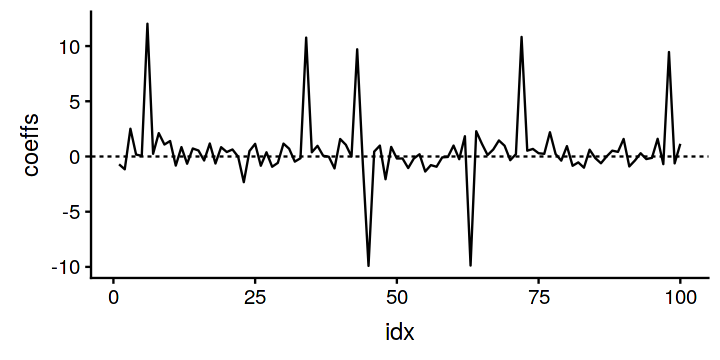

In [35]:
data.frame(idx=seq(b), coeffs=b) %>%
    ggplot(aes(idx, coeffs)) +
    geom_line() +
    hline_0(color="black", lty="dashed")

In [36]:
y <- X %*%b + rnorm(n)

In [37]:
model.file <- "_models/finnish_horse.stan"
cat(readLines(model.file), sep="\n")

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[N, M] X;
  real y[N];
}

// slab_scale = 5, slab_df = 25 -> 8 divergences

transformed data {
  real m0 = 10;           // Expected number of large slopes
  real slab_scale = 3;    // Scale for large slopes
  real slab_scale2 = square(slab_scale);
  real slab_df = 25;      // Effective degrees of freedom for large slopes
  real half_slab_df = 0.5 * slab_df;
}

parameters {
  vector[M] beta_tilde;
  vector<lower=0>[M] lambda;
  real<lower=0> c2_tilde;
  real<lower=0> tau_tilde;
  real alpha;
  real<lower=0> sigma;
}

transformed parameters {
  vector[M] beta;
  {
    real tau0 = (m0 / (M - m0)) * (sigma / sqrt(1.0 * N));
    real tau = tau0 * tau_tilde; // tau ~ cauchy(0, tau0)

    // c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
    // Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
    real c2 = slab_scale2 * c2_tilde;

    vector[M] lambda_tilde =
      sqrt( c2 

In [38]:
data <- list(
    N=n,
    M=p,
    X=X,    
    y=as.numeric(y)
)

In [39]:
finnish_fit <- stan(file=model.file, data=data, seed=23)


SAMPLING FOR MODEL 'finnish_horse' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00012 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.1278 seconds (Warm-up)
Chain 1:                9.31339 seconds (Sampling)
Chain 1:              

Warning message:
“There were 7 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”

In [54]:
finnish_fit

Inference for Stan model: finnish_horse.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean      sd    2.5%     25%     50%     75%   97.5%
beta_tilde[1]     -0.13    0.01    0.52   -1.38   -0.31   -0.07    0.07    1.00
beta_tilde[2]     -0.21    0.01    0.53   -1.55   -0.39   -0.12    0.01    0.85
beta_tilde[3]      2.30    0.01    0.37    1.69    2.05    2.26    2.49    3.17
beta_tilde[4]     -1.13    0.01    0.49   -2.35   -1.39   -0.99   -0.73   -0.54
beta_tilde[5]      0.96    0.01    0.53    0.34    0.53    0.83    1.28    2.21
beta_tilde[6]     -0.49    0.01    0.46   -1.74   -0.67   -0.35   -0.16   -0.02
beta_tilde[7]      0.28    0.01    0.52   -0.70    0.04    0.18    0.47    1.54
beta_tilde[8]      0.52    0.01    0.47    0.04    0.18    0.39    0.71    1.78
beta_tilde[9]     -0.86    0.01    0.50   -2.13   -1.13   -0.74   -0.47   -0.26
beta_tilde[10]    -0.01    0.01    0.54  